<a href="https://colab.research.google.com/github/Luo88-11-08/finlab/blob/master/normal_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install finlab > log.txt
!pip install ta-lib-bin > log.txt

In [ ]:
# Import necessary modules
from finlab import data, backtest
import talib

# Get financial data
當月營收 = data.get("monthly_revenue:當月營收")
revenue_growth_rate = data.get('fundamental_f0eatures:營收成長率')
roe = data.get('fundamental_features:ROE稅後')
pb_ratio = data.get('price_earning_ratio:股價淨值比')
volume = data.get('price:成交股數')
close = data.get('price:收盤價')

# 計算月營收斜率
def rev_growth_func(rev):
    return talib.LINEARREG_SLOPE(rev, timeperiod=12) / talib.LINEARREG_INTERCEPT(rev,12)

rev_grouwth = 當月營收.apply(rev_growth_func)

# Define selection criteria
revenue_growth_threshold = revenue_growth_rate.quantile(0.8, axis=1)
roe_threshold = roe.mean(axis=1)

# Find stocks meeting criteria
revenue_growth_stocks = revenue_growth_rate > revenue_growth_threshold
high_roe_stocks = (roe > roe.quantile(0.5, axis=1)).deadline()
rev_sl_compare = (當月營收.average(3) > 當月營收.average(12)) & (當月營收 > 當月營收.shift(12))

# Define buy condition
buy_condition = (

    # 把 ROE > 80% 改成 ROE > 50%，ROE 在台股會有回歸效應（ROE高不可持續，反而傷害股價）
    high_roe_stocks

    # 增加月營收成長的部分（台股才有月營收，資料公布時間更快）
    & (當月營收.pct_change().rolling(12).std() < 0.3)
    & rev_sl_compare

    # 把本益比換成股價淨值比（本益比在台股上直接用比較困難）
    & (pb_ratio < 2)

    # 增加流動性
    & (volume > 200000)

    # 回測後發現波動（風險）太大，選擇低風險特性的股票
    & (close.pct_change().rolling(60).std() < 0.025)
)

# 月營收增長最快的股票
position = rev_grouwth[buy_condition].is_largest(5)

# 調整換股時間為月營收截止日
position = position.reindex(當月營收.index_str_to_date().index)

# Simulate positions
report = backtest.sim(position, position_limit=0.2, upload=False)

輸入成功!


In [ ]:
import pandas as pd

d = pd.DataFrame({
    'strategy': report.creturn.resample('M').last().pct_change(),
    'benchmark': report.benchmark.loc[report.creturn.index[0]:].resample('M').last().pct_change()
}).dropna()

# 策略每月報酬，與大盤每月報酬的分佈

* 介紹如何看圖：每一根 bar 代表該月報酬率發生的機率
* 橘色是大盤的報酬率，藍色是策略的報酬率
* 你以為會差很多，其實根本差不多（而選股策略就是這樣，很正常）
* 眼睛是很難看清楚的，所以取 mean 跟 std 是最簡單的方式
* mean 明顯是策略高，高報酬的缺點就是高風險（std）。

,mean,std
strategy,0.030257,0.062462
benchmark,0.009840,0.041925


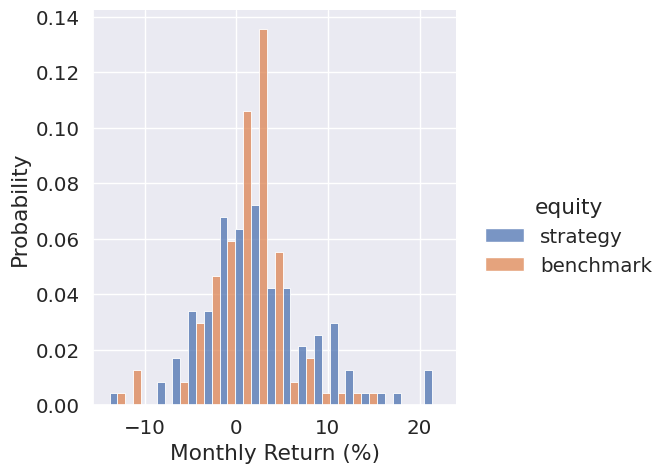

In [ ]:
import seaborn as sns

sns.set(rc={'figure.figsize':(16,9)})
sns.set(font_scale=1.3)

d_dist = d.unstack()\
    .reset_index()\
    .rename(columns={'level_0': 'equity', 0:'Monthly Return (%)'})\

d_dist['Monthly Return (%)'] *= 100
sns.displot(data=d_dist, x='Monthly Return (%)', hue="equity", stat="probability", multiple="dodge", fill=True)
pd.DataFrame({'mean': d.mean(), 'std': d.std()})

# 上圖有點複雜，密度估計圖（KDE），讓它看起來更像是分佈圖
* 大盤很高的機率當月會不上不下
* 策略更具有有長尾效應（賺爆賺、賠爆賠）
* 個股也是如此（長尾），所以才說停損很重要，因為小賠容易變大賠，小賺容易變大賺，所以停利...讓子彈飛一會吧（台股）！

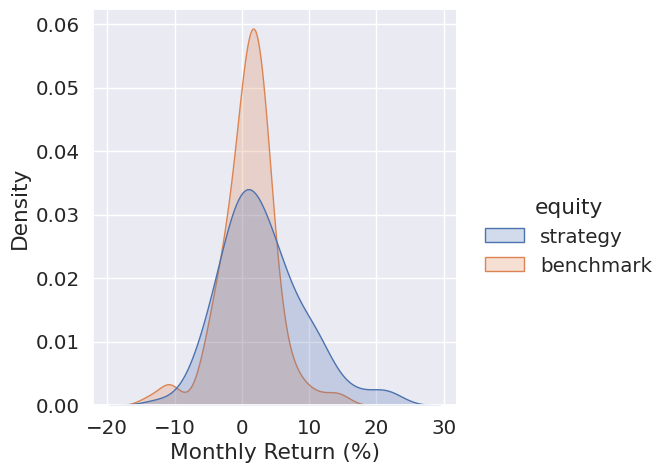

In [ ]:
import seaborn as sns

sns.set(rc={'figure.figsize':(16,9)})
sns.set(font_scale=1.3)

d_dist = d.unstack()\
    .reset_index()\
    .rename(columns={'level_0': 'equity', 0:'Monthly Return (%)'})\

d_dist['Monthly Return (%)'] *= 100
sns.displot(data=d_dist, x='Monthly Return (%)', hue="equity", kind="kde", fill=True)

strategy     0.030257
benchmark    0.009840
dtype: float64

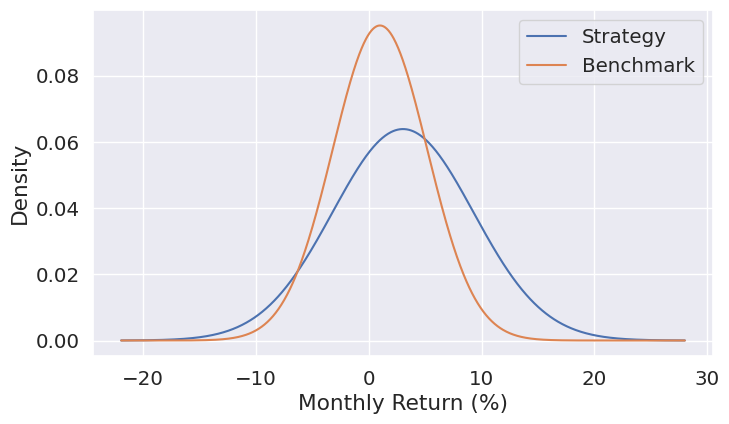

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm


sns.set(rc={'figure.figsize':(16/2,9/2)})
sns.set(font_scale=1.3)


mean0, std0 = d.mean()['strategy'] * 100, d.std()['strategy'] * 100
mean1, std1 = d.mean()['benchmark'] * 100, d.std()['benchmark'] * 100


# Create an array of x values for the PDFs
x = np.linspace(min(mean0 - 4 * std0, mean1 - 4 * std1), max(mean0 + 4 * std0, mean1 + 4 * std1), 1000)

# Calculate the PDFs for the given means and standard deviations
pdf0 = norm.pdf(x, mean0, std0)
pdf1 = norm.pdf(x, mean1, std1)

# Plot the two normal distributions
sns.lineplot(x=x, y=pdf0, label='Strategy')
sns.lineplot(x=x, y=pdf1, label='Benchmark')


plt.xlabel('Monthly Return (%)')
plt.ylabel('Density')
plt.legend()
plt.show()

# 二維分佈（探討兩個分佈之間的相關性）
* 身高越高智商越高？
* 喝越多咖啡越長壽？
* 大盤報酬好，策略報酬好？（答案是肯定的）
* 下圖散部圖，呈現右上左下分佈，代表大盤與策略有正相關性，正相關可以做很多事：
    * 找財報、月報、價格數據，是否與未來正相關？進而找出有用的指標。

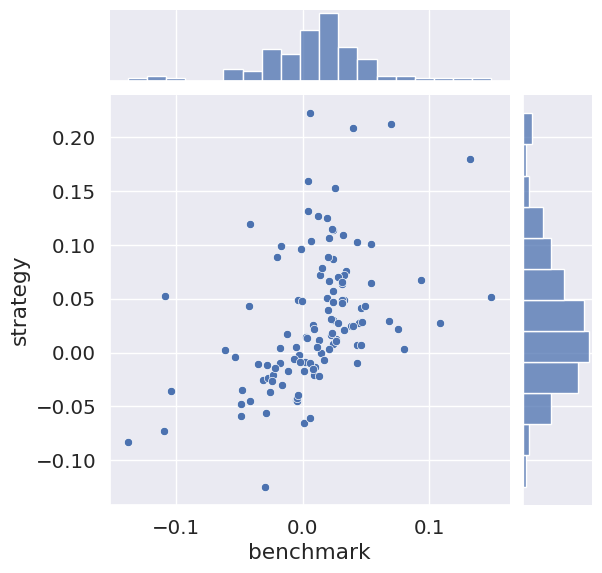

In [ ]:
import seaborn as sns
sns.jointplot(data=d, x="benchmark", y="strategy")

# 用密度估計圖（KDE），更清楚

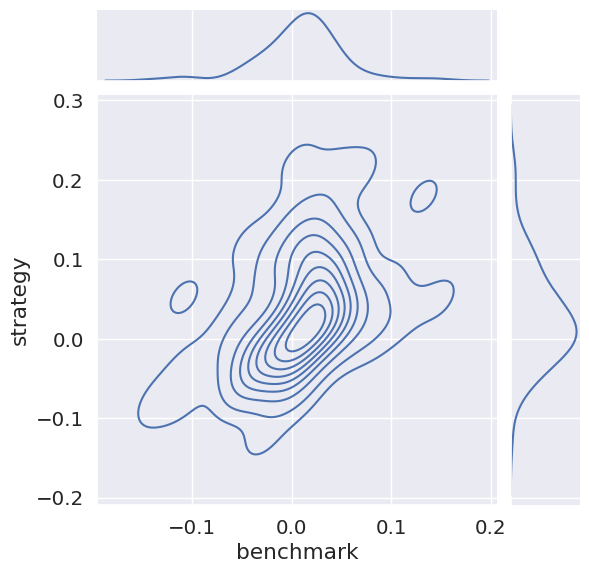

In [ ]:
sns.jointplot(
    data=d, x="benchmark", y="strategy",
    kind="kde"
)